In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats, integrate
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 
%matplotlib inline

In [9]:
# https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
from google.colab import files
uploaded = files.upload()

Saving Submission.csv to Submission (1).csv
Saving Test.csv to Test (1).csv
Saving Train.csv to Train (1).csv


In [0]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
train_original=train.copy() 
test_original=test.copy()

In [11]:
train_original.head(3)

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6


In [12]:
test_original.head(3)

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00


In [13]:
train_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
ID          18288 non-null int64
Datetime    18288 non-null object
Count       18288 non-null int64
dtypes: int64(2), object(1)
memory usage: 428.8+ KB


In [14]:
test_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5112 entries, 0 to 5111
Data columns (total 2 columns):
ID          5112 non-null int64
Datetime    5112 non-null object
dtypes: int64(1), object(1)
memory usage: 80.0+ KB


In [0]:
import datetime #cast datetime AS datetime rather than object

In [0]:
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M',infer_datetime_format=True) 
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M', infer_datetime_format=True) 
test_original['Datetime'] = pd.to_datetime(test_original.Datetime,format='%d-%m-%Y %H:%M', infer_datetime_format=True) 
train_original['Datetime'] = pd.to_datetime(train_original.Datetime,format='%d %m %Y %H:%M',  infer_datetime_format=True)

In [17]:
test_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5112 entries, 0 to 5111
Data columns (total 2 columns):
ID          5112 non-null int64
Datetime    5112 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 80.0 KB


In [0]:
#extract year, month, day, hour
for entry in (train, test, test_original, train_original):
    entry['year']=entry.Datetime.dt.year 
    entry['month']=entry.Datetime.dt.month 
    entry['day']=entry.Datetime.dt.day
    entry['Hour']=entry.Datetime.dt.hour 

In [19]:
#let's look at the day of the week and assign values based on whether the day is a weekday or weekend
train['day of week']=train['Datetime'].dt.dayofweek 
temp = train['Datetime']
temp.head(3)

0   2012-08-25 00:00:00
1   2012-08-25 01:00:00
2   2012-08-25 02:00:00
Name: Datetime, dtype: datetime64[ns]

In [20]:
print("TRAIN")
print(train.head(3))
print("TEST")
print(test.head(3))

TRAIN
   ID            Datetime  Count  year  month  day  Hour  day of week
0   0 2012-08-25 00:00:00      8  2012      8   25     0            5
1   1 2012-08-25 01:00:00      2  2012      8   25     1            5
2   2 2012-08-25 02:00:00      6  2012      8   25     2            5
TEST
      ID            Datetime  year  month  day  Hour
0  18288 2014-09-26 00:00:00  2014      9   26     0
1  18289 2014-09-26 01:00:00  2014      9   26     1
2  18290 2014-09-26 02:00:00  2014      9   26     2


In [0]:
def binarify(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0
temp2 = train['Datetime'].apply(binarify)
train['weekend']=temp2

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


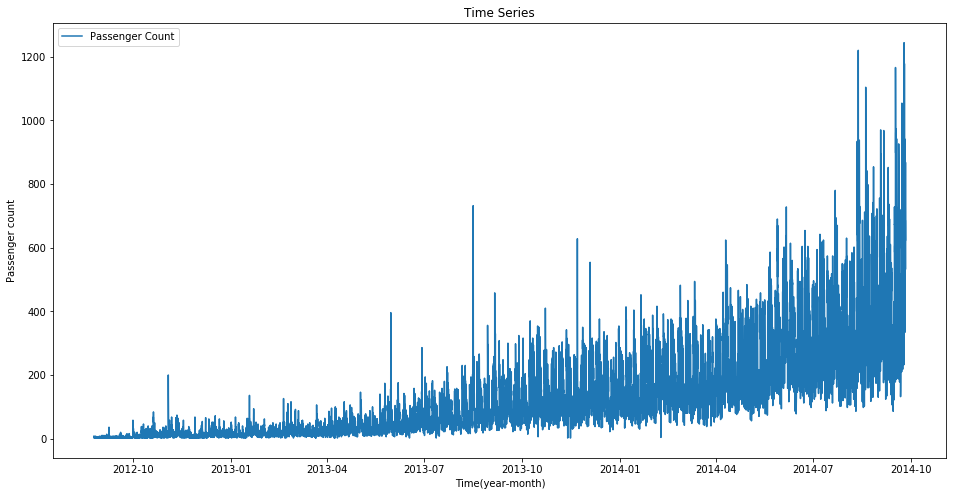

In [22]:
from pandas.plotting import register_matplotlib_converters

train.index = train['Datetime'] 
df=train.drop('ID',1) #drop ID so x-axis = Datetime
ts = df['Count'] 
plt.figure(figsize=(16,8)) 
plt.plot(ts, label='Passenger Count') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Passenger count") 
plt.legend(loc='best')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


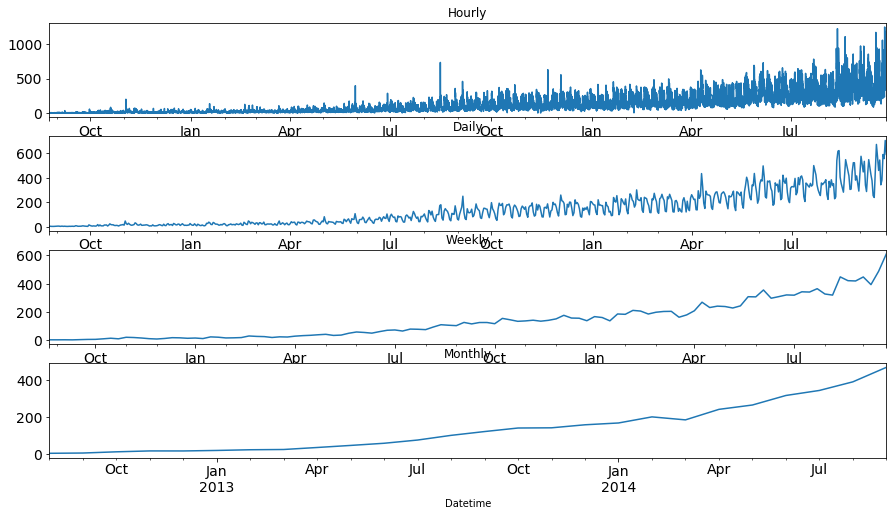

In [23]:
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
train.index = train.Timestamp
hourly = train.resample('H').mean()
daily = train.resample('D').mean()
weekly = train.resample('W').mean()
monthly = train.resample('M').mean()
fig, axs = plt.subplots(4,1) 
hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0]) 
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1])
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2]) 
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3])

In [24]:
train.shape, test.shape

((18288, 9), (5112, 6))

In [25]:
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp  
test = test.resample('D').mean() #convert to daily mean

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [0]:
Train=train.loc['2012-08-25':'2014-06-24'] 
valid=train.loc['2014-06-25':'2014-09-25']

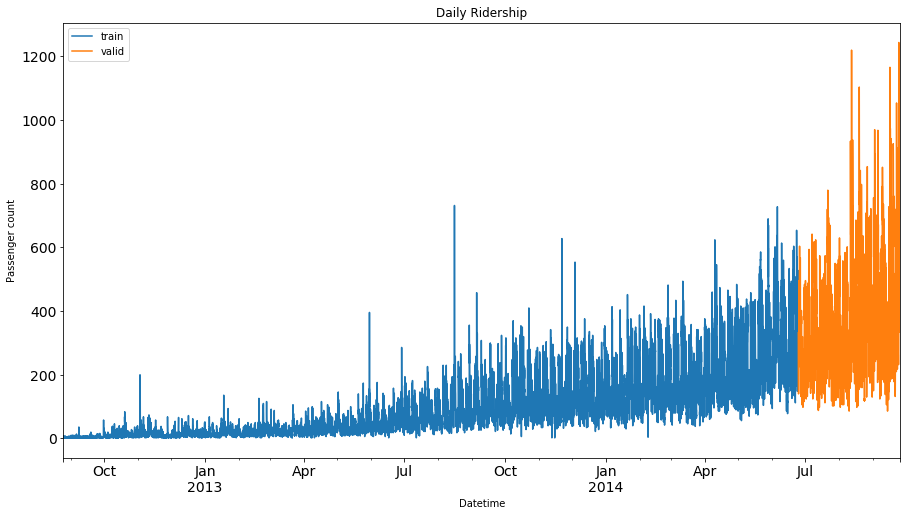

In [27]:
Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train') 
valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid') 
plt.xlabel("Datetime") 
plt.ylabel("Passenger count") 
plt.legend(loc='best') 
plt.show()

# And now our Holt-Winters model!

Holt-Winters models take both _trends_ and _seasonality_ into account

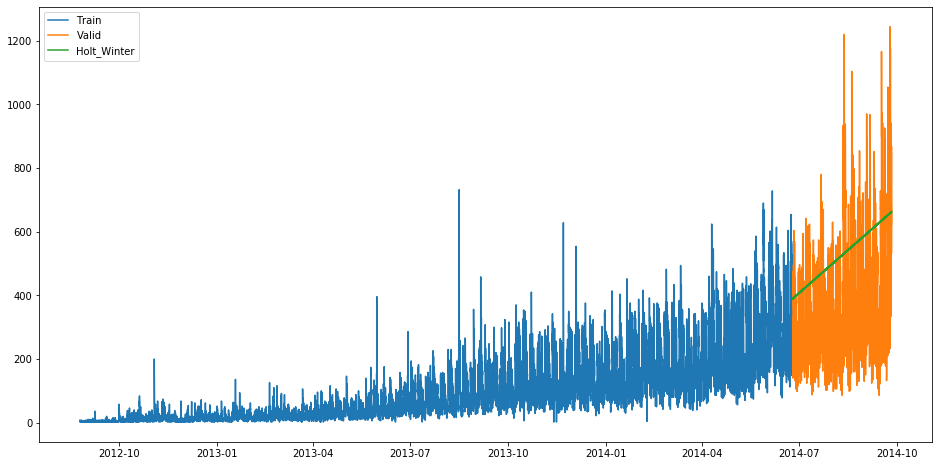

In [28]:
y_hat_avg = valid.copy() 
fit1 = ExponentialSmoothing(np.asarray(Train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit() 
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter') 
plt.legend(loc='best') 
plt.show()

In [30]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(valid.Count, y_hat_avg.Holt_Winter))

# rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_Winter)) 
# print(rms)

50480.625306248614


In [34]:
import math


math.sqrt(50480.625306248614)

224.6789382791556

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


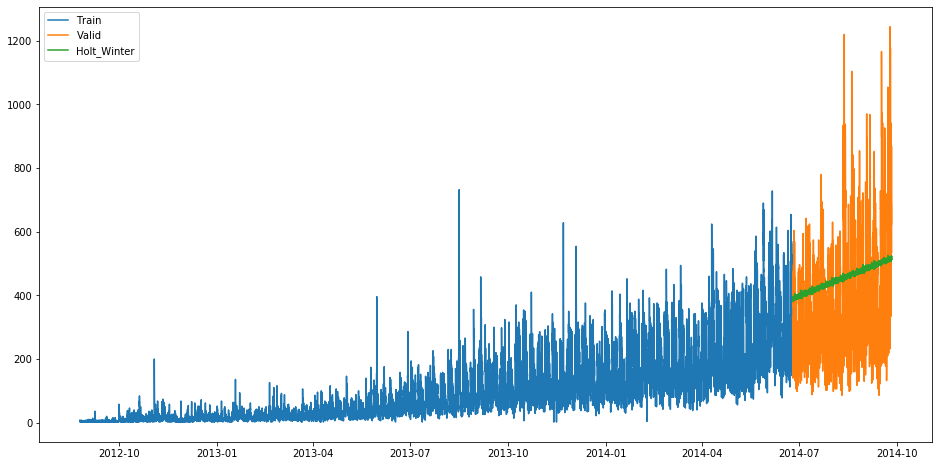

In [36]:
y_hat_avg = valid.copy() 
fit1 = ExponentialSmoothing(np.asarray(Train['Count']) ,seasonal_periods=700 ,trend='add', seasonal='add',).fit() 
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter') 
plt.legend(loc='best') 
plt.show()

Oh dear

In [37]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(valid.Count, y_hat_avg.Holt_Winter))

# rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_Winter)) 
# print(rms)

35794.20334780581


In [38]:
math.sqrt(35794.20334780581)

189.19356053472276